## CNN (Red Neuronal Convulucional)

Modelo de CNN para clasificar imágenes de melanomas en benigno o maligno

#### 1. Configurar y cargar datos

In [1]:
import tensorflow as tf
import os 

In [2]:
# Ruta de tu directorio donde se encuentran las imágenes
base_dir = 'Cancer'

# Directorios de entrenamiento y prueba
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Imprimir las subcarpetas dentro de train y test
print(f"Carpetas en train: {os.listdir(train_dir)}")  
print(f"Carpetas en test: {os.listdir(test_dir)}")

Carpetas en train: ['Malignant', 'Benign']
Carpetas en test: ['Malignant', 'Benign']


#### 2. Limpieza datos

In [4]:
import os
import imghdr

def count_invalid_images(directory_path):
    """
    Cuenta la cantidad de archivos que no son imágenes válidas en un directorio.
    
    Args:
    directory_path (str): Ruta al directorio que contiene las imágenes.
    
    Returns:
    int: El número de archivos no válidos.
    """
    supported_formats = {'jpeg', 'png', 'gif', 'bmp'}  # Formatos de imagen soportados por TensorFlow
    invalid_images = 0

    # Recorre el directorio y sus subdirectorios
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            # Verifica si el archivo es una imagen
            image_format = imghdr.what(file_path)
            if image_format not in supported_formats:
                invalid_images += 1
                print(f"Archivo no válido: {file_path}")

    return invalid_images

# Ruta de los directorios donde están las imágenes
train_dir = 'C:\\Users\\FX507\\Downloads\\002.Cancer\\train'
test_dir = 'C:\\Users\\FX507\\Downloads\\002.Cancer\\test'

# Contar imágenes no válidas en los conjuntos de entrenamiento y prueba
invalid_train_images = count_invalid_images(train_dir)
invalid_test_images = count_invalid_images(test_dir)

# Mostrar los resultados
print(f"Imágenes no válidas en el set de entrenamiento: {invalid_train_images}")
print(f"Imágenes no válidas en el set de prueba: {invalid_test_images}")

Imágenes no válidas en el set de entrenamiento: 0
Imágenes no válidas en el set de prueba: 0


/var/folders/98/7bgvzcwx7tz2bgwyh060mq100000gn/T/ipykernel_94011/6249078.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Todas las imágenes son válidas

#### 3.Cargamos los datos

Found 11879 images belonging to 2 classes.
Tamaño de las imágenes: (32, 128, 128, 3)
Etiquetas del lote: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0.]


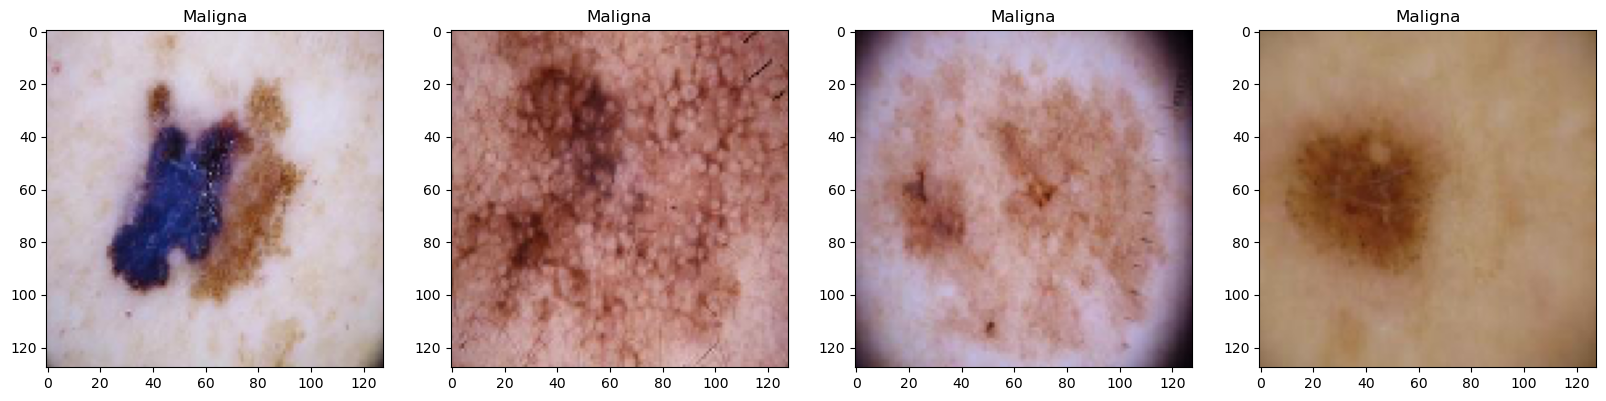

In [5]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os

# Ruta de los directorios donde están las imágenes
train_dir = 'Cancer/train'

# Preprocesamiento de imágenes (normalización)
img_size = (128, 128)
batch_size = 32

# Generador para cargar imágenes desde el directorio
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde el directorio de entrenamiento
data_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'  # Clasificación binaria (benign/malignant)
)

# Obtener el primer lote de imágenes utilizando next()
data_iterator = iter(data_images)
batch = next(data_iterator)  # Esto obtiene el primer lote

# Mostrar el tamaño de las imágenes en el lote
print(f"Tamaño de las imágenes: {batch[0].shape}")

# Mostrar las etiquetas de las imágenes en el lote
print(f"Etiquetas del lote: {batch[1]}")

# Visualizar las primeras 4 imágenes del lote con sus etiquetas
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text('Benigna' if batch[1][idx] == 0 else 'Maligna')

plt.show()


In [6]:
# Definimos la ruta a los datos
data_directory = 'Cancer/train'

# Configuramos el aumento de datos utilizando la API de preprocesamiento de Keras
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

# Preprocesamos los datos y cargamos usando image_dataset_from_directory
def preprocess(x, y):
    x = data_augmentation(x)
    x = x / 255.0
    return x, y

data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    label_mode='int',
    image_size=(256, 256)
)

data = data.map(preprocess)

Found 11879 files belonging to 2 classes.


#### 4. Dividimos los datos

In [7]:
# Dividimos los datos
dataset_size = len(data)
train_size = int(0.7 * dataset_size)
val_size = int(0.3 * dataset_size)
test_size = dataset_size - train_size - val_size

# Crear datasets para entrenamiento, validación y prueba
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)


#### 5. Creamos el modelo

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    tf.keras.layers.Dense(1, activation='sigmoid')  # Clasificación binaria (benigna/maligna)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

#### 6. Entrenamos el modelo

In [9]:
from tensorflow.keras.callbacks import TensorBoard
# Callback para TensorBoard
log_dir = '../../logs'
tensorboard_callback = TensorBoard(log_dir=log_dir)
# Entrenamiento del modelo
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_data, epochs=7, validation_data=val_data, callbacks=[tensorboard_callback, early_stopping])
 

Epoch 1/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.7012 - loss: 0.6342 - val_accuracy: 0.6765 - val_loss: 0.6034
Epoch 2/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.7991 - loss: 0.4498 - val_accuracy: 0.8325 - val_loss: 0.4029
Epoch 3/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.8224 - loss: 0.4089 - val_accuracy: 0.8463 - val_loss: 0.3555
Epoch 4/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.8163 - loss: 0.4162 - val_accuracy: 0.8328 - val_loss: 0.3654
Epoch 5/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8181 - loss: 0.4126 - val_accuracy: 0.8423 - val_loss: 0.3557
Epoch 6/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.8349 - loss: 0.3941 - val_accuracy: 0.8432 - val_loss: 0.3547
Epoch 7/7
260/260 ━━━━━━━━━━━━━━━━━━━━ 827s 3s/step - accuracy: 0.8279 - loss: 0.3965 - val_accuracy: 0.8356 - val_loss: 0.3727


#### 7. Visualización

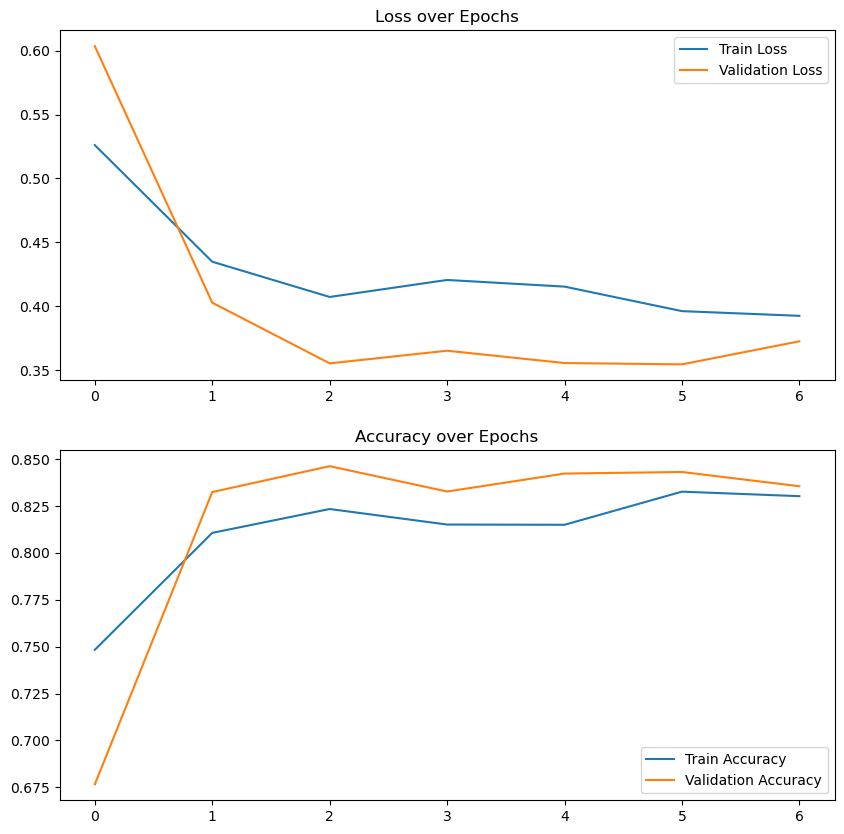

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss over Epochs')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy over Epochs')
axs[1].legend()
plt.show()

#### 8. Evaluamos el modelo

In [14]:
from tensorflow.keras.metrics import Precision, Recall

# Inicializamos las métricas
precision = Precision()
recall = Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

# Iteramos sobre el conjunto de prueba
for batch in test_data:
    X, y = batch
    yhat = model.predict(X)
    # Convertimos las probabilidades en etiquetas binarias (0 o 1)
    yhat_labels = tf.where(yhat > 0.5, 1, 0)
    
    # Actualizamos las métricas
    precision.update_state(y, yhat_labels)
    recall.update_state(y, yhat_labels)
    accuracy.update_state(y, yhat_labels)

# Imprimimos los resultados de las métricas
print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-10-20 20:10:25.962262: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### 9. Prueba

Found 2000 images belonging to 2 classes.


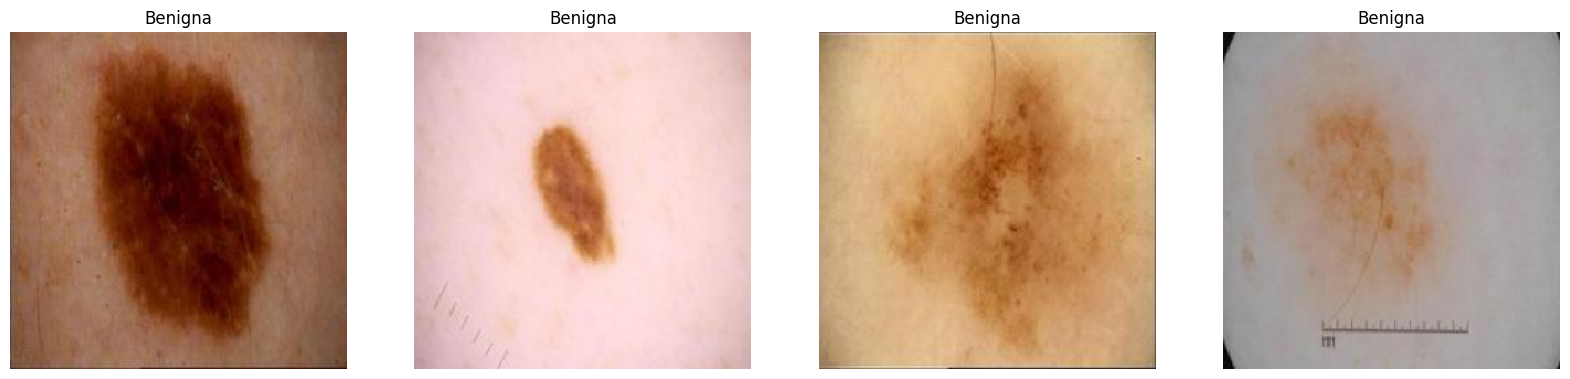

In [32]:
# Generador para cargar imágenes desde el directorio de prueba
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde el directorio de prueba
test_data = test_datagen.flow_from_directory(
    test_dir,  # Carpeta de prueba
    target_size=(256, 256),  # Tamaño de las imágenes (el mismo que en entrenamiento)
    batch_size=32,
    class_mode='binary',  # Clasificación binaria
    shuffle=False  # No barajar, ya que solo estamos evaluando
)

# Mostrar algunas imágenes del conjunto de prueba
import matplotlib.pyplot as plt
import numpy as np

# Obtener el primer lote de imágenes del conjunto de prueba
test_images, test_labels = next(iter(test_data))

# Visualizar las primeras 4 imágenes con sus etiquetas
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    axes[i].imshow(test_images[i])
    axes[i].set_title(f'{"Benigna" if test_labels[i] == 0 else "Maligna"}')
    axes[i].axis('off')

plt.show()


c:\Users\FX507\Documents\GitHub\Deteccion_melanomas\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.8406 - loss: 0.3527
Pérdida en el conjunto de prueba: 0.35926178097724915
Precisión en el conjunto de prueba: 0.8504999876022339
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step
Precisión: 0.8347659980897804
Recall: 0.874
Accuracy: 0.8505


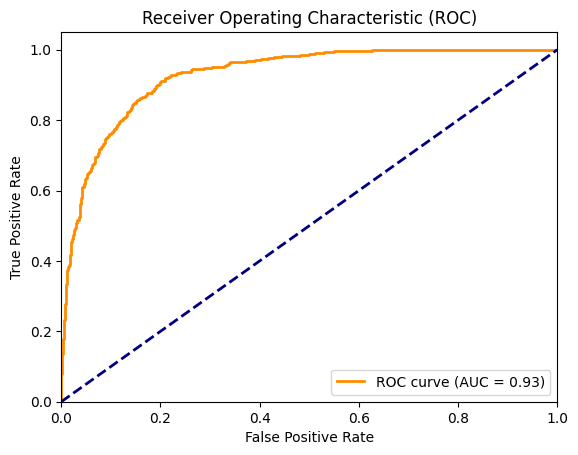

In [33]:
# Evaluar el modelo usando el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_data)

print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

# A partir de aquí, puedes añadir la curva ROC y las métricas adicionales
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias

# Calcular las métricas
precision = precision_score(test_data.classes, y_pred)
recall = recall_score(test_data.classes, y_pred)
accuracy = accuracy_score(test_data.classes, y_pred)

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step
Umbral óptimo basado en la curva ROC: 0.4531245827674866
Precisión con umbral óptimo: 0.819081908190819
Recall con umbral óptimo: 0.91
Exactitud con umbral óptimo: 0.8545


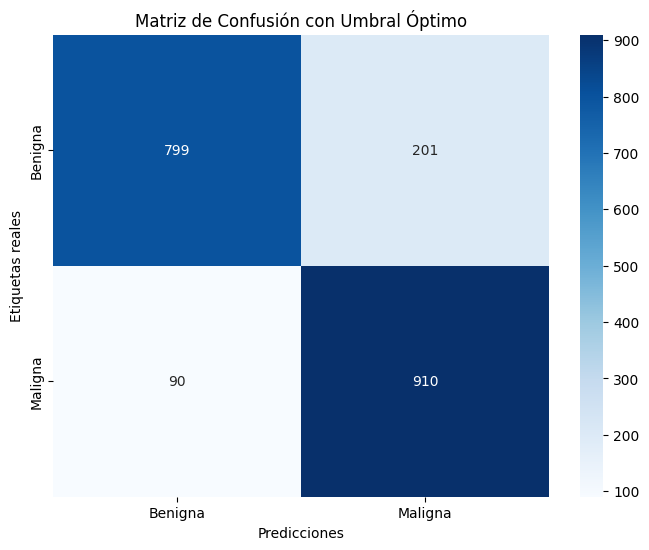

In [34]:
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc

# Obtener las probabilidades predichas por el modelo
y_pred_prob = model.predict(test_data)
y_true = test_data.classes  # Etiquetas reales del conjunto de prueba


# Calcular la curva ROC y los umbrales
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)

# Calcular la diferencia entre TPR y FPR para encontrar el umbral óptimo
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds_roc[optimal_idx]

print(f"Umbral óptimo basado en la curva ROC: {optimal_threshold}")

# Calcular las métricas con el umbral óptimo
y_pred_optimal = (y_pred_prob > optimal_threshold).astype(int)

precision_optimal = precision_score(y_true, y_pred_optimal)
recall_optimal = recall_score(y_true, y_pred_optimal)
accuracy_optimal = accuracy_score(y_true, y_pred_optimal)

print(f'Precisión con umbral óptimo: {precision_optimal}')
print(f'Recall con umbral óptimo: {recall_optimal}')
print(f'Exactitud con umbral óptimo: {accuracy_optimal}')

# Mostrar la matriz de confusión con el umbral óptimo
cm_optimal = confusion_matrix(y_true, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt="d", cmap="Blues", xticklabels=["Benigna", "Maligna"], yticklabels=["Benigna", "Maligna"])
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas reales')
plt.title('Matriz de Confusión con Umbral Óptimo')
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step

### Umbral: 0.4 ###
Precisión: 0.7976088812980359
Recall: 0.934
Accuracy: 0.8485


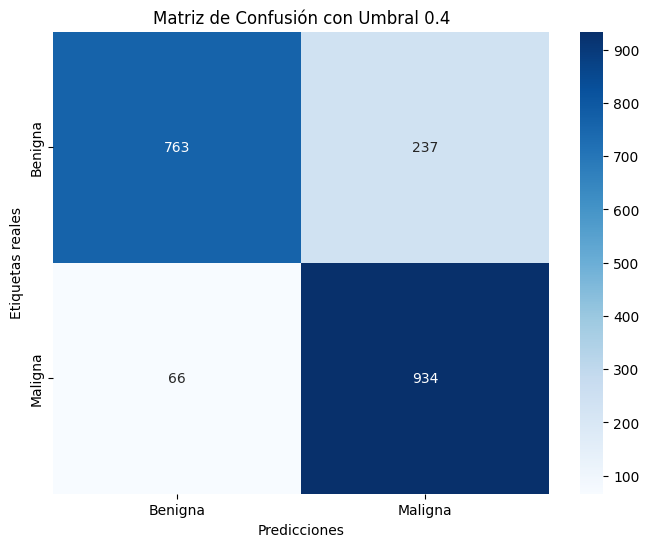


### Umbral: 0.35 ###
Precisión: 0.7672343876723439
Recall: 0.946
Accuracy: 0.8295


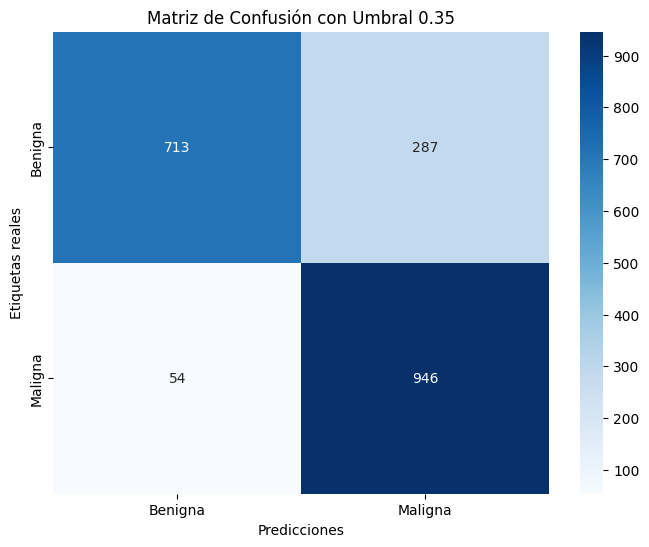


### Umbral: 0.2 ###
Precisión: 0.6950959488272921
Recall: 0.978
Accuracy: 0.7745


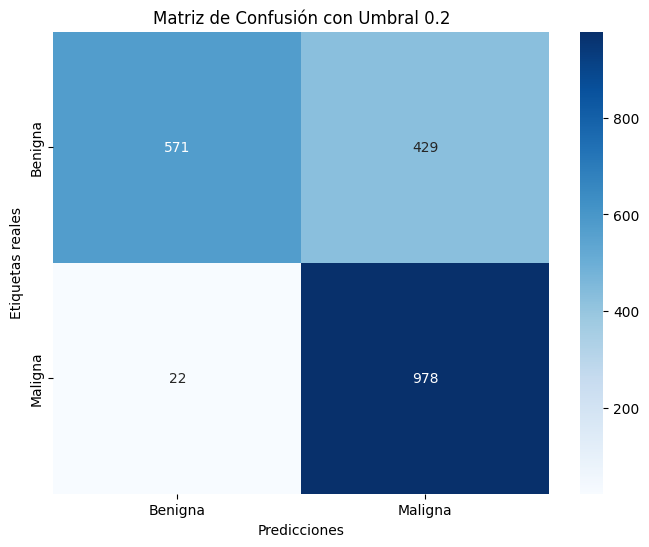


### Umbral: 0.275 ###
Precisión: 0.7353165522501907
Recall: 0.964
Accuracy: 0.8085


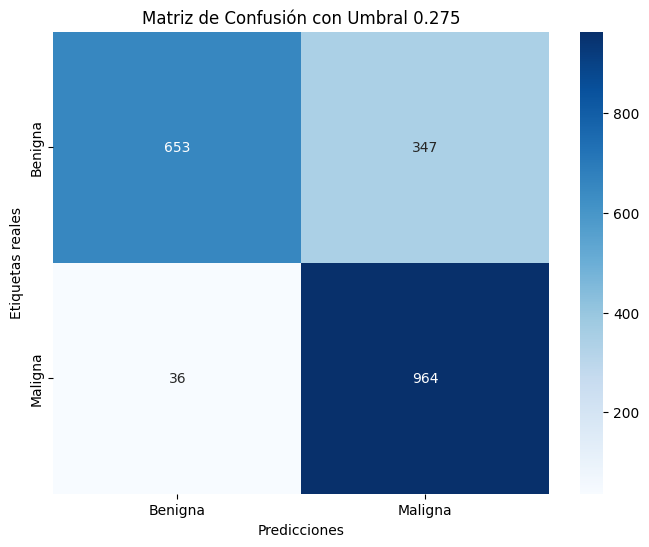


### Umbral: 0.23 ###
Precisión: 0.7101024890190337
Recall: 0.97
Accuracy: 0.787


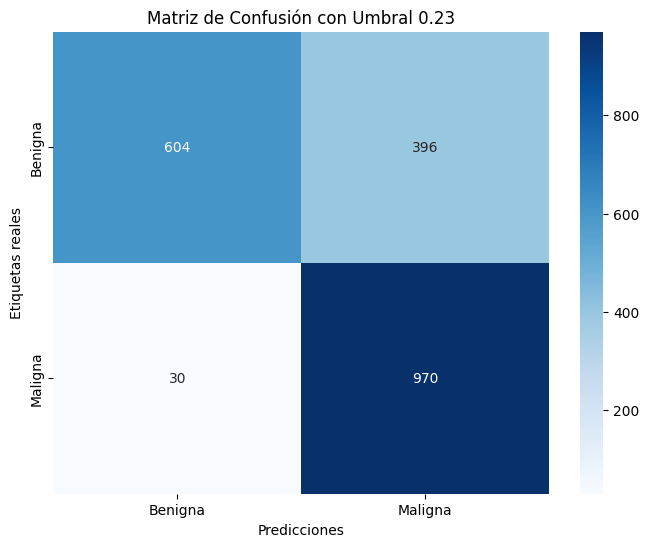


### Umbral: 0.25 ###
Precisión: 0.7216417910447761
Recall: 0.967
Accuracy: 0.797


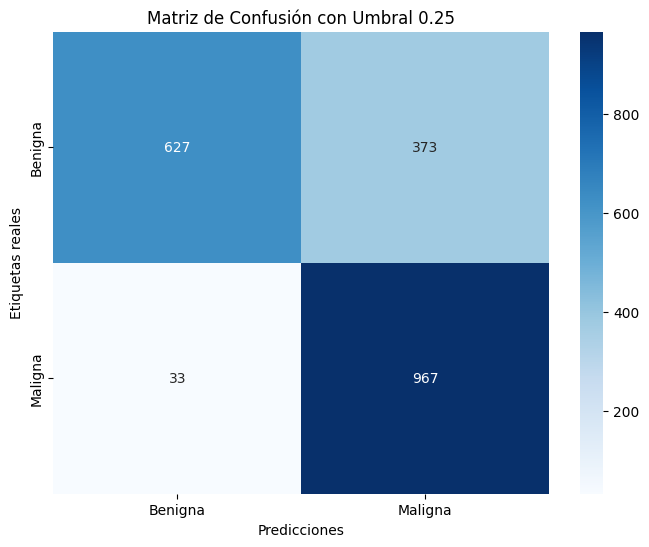

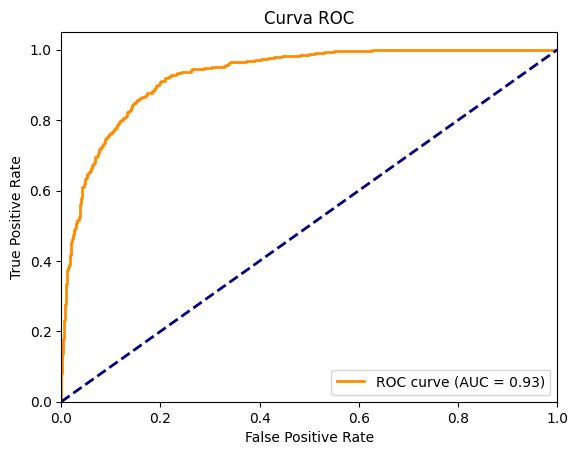

In [35]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las probabilidades predichas por el modelo
y_pred_prob = model.predict(test_data)
y_true = test_data.classes  # Etiquetas reales del conjunto de prueba

# Listado de umbrales que vamos probar
thresholds = [ 0.4, 0.35, 0.2, 0.275, 0.23, 0.25]

# Iterar sobre los diferentes umbrales y calcular métricas para cada uno
for threshold in thresholds:
    print(f"\n### Umbral: {threshold} ###")
    
    # Convertir probabilidades en etiquetas binarias basadas en el umbral
    y_pred_adjusted = (y_pred_prob > threshold).astype(int)

    # Calcular métricas con el nuevo umbral
    precision = precision_score(y_true, y_pred_adjusted)
    recall = recall_score(y_true, y_pred_adjusted)
    accuracy = accuracy_score(y_true, y_pred_adjusted)

    print(f'Precisión: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    
    # Matriz de confusión para cada umbral
    cm = confusion_matrix(y_true, y_pred_adjusted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benigna", "Maligna"], yticklabels=["Benigna", "Maligna"])
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    plt.title(f'Matriz de Confusión con Umbral {threshold}')
    plt.show()

# ---- Generar la curva ROC ----

# Calcular la curva ROC para el modelo
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step


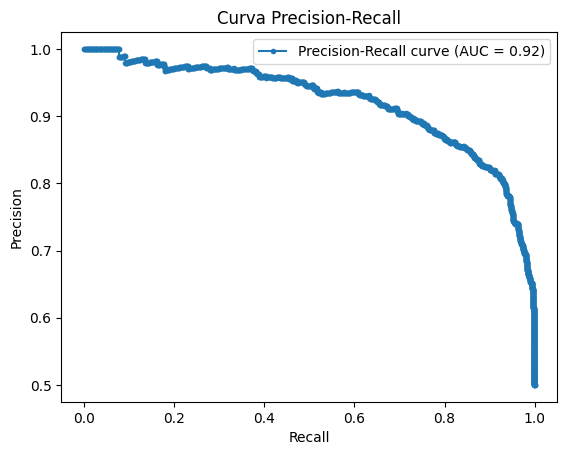

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Obtener las probabilidades predichas por el modelo
y_pred_prob = model.predict(test_data)  # Probabilidades predichas
y_true = test_data.classes  # Etiquetas reales del conjunto de prueba

# Calcular los valores de precisión, recall y los umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Calcular el área bajo la curva (AUC) Precision-Recall
auc_pr = auc(recall, precision)

# Graficar la curva Precision-Recall
plt.figure()
plt.plot(recall, precision, marker='.', label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='best')
plt.show()


#### 10. Guardamos el modelo


In [37]:
model.save('modelo_final_cnn.h5')

#### 11. Prueba con imágeness

Mostrando hasta 10 imágenes de cada categoría (Benigna/Maligna):
1. 6299.jpg (Carpeta: Benign)
2. 6300.jpg (Carpeta: Benign)
3. 6301.jpg (Carpeta: Benign)
4. 6302.jpg (Carpeta: Benign)
5. 6303.jpg (Carpeta: Benign)
6. 6304.jpg (Carpeta: Benign)
7. 6305.jpg (Carpeta: Benign)
8. 6306.jpg (Carpeta: Benign)
9. 6307.jpg (Carpeta: Benign)
10. 6308.jpg (Carpeta: Benign)
11. 5602.jpg (Carpeta: Malignant)
12. 5603.jpg (Carpeta: Malignant)
13. 5604.jpg (Carpeta: Malignant)
14. 5605.jpg (Carpeta: Malignant)
15. 5606.jpg (Carpeta: Malignant)
16. 5607.jpg (Carpeta: Malignant)
17. 5608.jpg (Carpeta: Malignant)
18. 5609.jpg (Carpeta: Malignant)
19. 5610.jpg (Carpeta: Malignant)
20. 5611.jpg (Carpeta: Malignant)


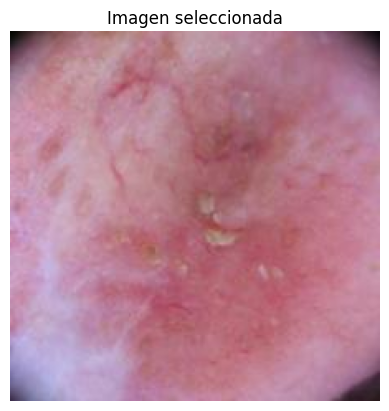

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Probabilidad de que sea benigna: 0.15
Probabilidad de que sea maligna: 0.85
La clase predicha es Maligno


In [62]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# Función para cargar y mostrar un número limitado de imágenes disponibles en las subcarpetas de 'test'
def mostrar_opciones_imagenes(test_dir, limite=10):
    subcarpetas = ['Benign', 'Malignant']  # Las subcarpetas dentro de test
    imagenes_disponibles = []

    for subcarpeta in subcarpetas:
        carpeta_completa = os.path.join(test_dir, subcarpeta)
        imagenes_subcarpeta = os.listdir(carpeta_completa)

        # Seleccionamos solo las primeras 'limite' imágenes de cada subcarpeta
        imagenes_disponibles += [(subcarpeta, img) for img in imagenes_subcarpeta[:limite]]

    # Mostrar las imágenes disponibles, limitado por el valor de 'limite'
    print(f"Mostrando hasta {limite} imágenes de cada categoría (Benigna/Maligna):")
    for i, (subcarpeta, imagen) in enumerate(imagenes_disponibles, start=1):
        print(f"{i}. {imagen} (Carpeta: {subcarpeta})")

    return imagenes_disponibles

# Solicitar al usuario que seleccione una imagen
def seleccionar_imagen(imagenes_disponibles, test_dir):
    opcion_imagen = input("Seleccione el número de la imagen que desea analizar: ")

    if opcion_imagen.isdigit() and 1 <= int(opcion_imagen) <= len(imagenes_disponibles):
        subcarpeta, nombre_imagen = imagenes_disponibles[int(opcion_imagen) - 1]
        ruta_imagen = os.path.join(test_dir, subcarpeta, nombre_imagen)
        return ruta_imagen
    else:
        print("Opción inválida.")
        return None

# Función para cargar una imagen, preprocesarla, mostrarla y hacer predicciones
def predecir_imagen(ruta_imagen, model, threshold=0.23):
    # Cargar la imagen usando OpenCV
    img = cv2.imread(ruta_imagen)

    if img is None:
        print("Error: La imagen no se pudo cargar.")
        return

    # OpenCV carga la imagen en BGR, la convertimos a RGB para mostrarla correctamente con matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen seleccionada
    plt.imshow(img_rgb)
    plt.title('Imagen seleccionada')
    plt.axis('off')  # No mostrar los ejes para una mejor visualización
    plt.show()

    # Redimensionar la imagen para que coincida con el tamaño de entrada del modelo
    resize = tf.image.resize(img_rgb, (256, 256))

    # Preparar la imagen para la predicción (añadir una dimensión de batch y normalizar)
    img_array = np.expand_dims(resize / 255, axis=0)

    # Realizar la predicción usando el modelo previamente cargado
    yhat = model.predict(img_array)

    # Probabilidad de que sea maligna (como es binario, yhat[0][0] da esa probabilidad)
    malignant_probability = yhat[0][0]
    benign_probability = 1 - malignant_probability  # La probabilidad de que sea benigna es el complemento

    # Aplicar el umbral para clasificar
    if malignant_probability > threshold:
        predicted_class_name = "Maligno"
    else:
        predicted_class_name = "Benigno"

    # Imprimir los resultados
    print(f'Probabilidad de que sea benigna: {benign_probability:.2f}')
    print(f'Probabilidad de que sea maligna: {malignant_probability:.2f}')
    print(f'La clase predicha es {predicted_class_name}')

# MAIN: Cargar el modelo y realizar predicciones

# Cargar el modelo guardado (asegúrate de que 'mi_modelo.h5' esté en el mismo directorio o usa la ruta correcta)
model = load_model('modelo_final_cnn.h5')

# Ruta de la carpeta 'test'
test_dir = 'C:\\Users\\FX507\\Downloads\\002.Cancer\\test'

# Mostrar un número limitado de imágenes (por ejemplo, 10 de cada tipo)
imagenes_disponibles = mostrar_opciones_imagenes(test_dir, limite=10)
ruta_imagen = seleccionar_imagen(imagenes_disponibles, test_dir)

# Si se seleccionó una imagen válida, mostrarla y hacer la predicción
if ruta_imagen:
    predecir_imagen(ruta_imagen, model)
